In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import random
import math
import tqdm
from qulacs import PauliOperator, Observable, QuantumState,GeneralQuantumOperator
#GPU版をインストールしている場合のみ
#from qulacs import QuantumStateGpu
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs.state import inner_product
from qulacs.gate import *
from qulacs import ParametricQuantumCircuit


def show_observable(hamiltonian):
    for j in range(hamiltonian.get_term_count()):
        pauli=hamiltonian.get_term(j)

        # Get the subscript of each pauli symbol
        index_list = pauli.get_index_list()

        # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
        pauli_id_list = pauli.get_pauli_id_list()

        # Get pauli coefficient
        coef = pauli.get_coef()

        # Create a copy of pauli operator
        another_pauli = pauli.copy()

        s = ["I","X","Y","Z"]
        pauli_str = [s[i] for i in pauli_id_list]
        terms_str = [item[0]+str(item[1]) for item in zip(pauli_str,index_list)]
        full_str = str(coef) + " " + " ".join(terms_str)
        print(full_str)

def ensemble_avarage(hairetu,sampling_num,sycle):
    return_hairetu=[]
    for i in range(int(sycle)):
        sigma_sum = 0
        for h in range(sampling_num):
            sigma_sum = sigma_sum + hairetu[h][i]
        sigma_sum = sigma_sum / sampling_num
        return_hairetu.append(sigma_sum)
    return return_hairetu

# 量子アニーリングをノイズありでシミュレーションする
ノイズなしシミュレーション


In [2]:
def add_ZZ_interactions(operator,ListOfInt,ListOfJij):
    nqubits = operator.get_qubit_count()
    
    for k in range(len(ListOfInt)):
        operator.add_operator(ListOfJij[k],"Z {0}".format(ListOfInt[k][0])+"Z {0}".format(ListOfInt[k][1]))
    return operator


def add_X_fields(operator,field):
    nqubits = operator.get_qubit_count()
    for k in range(nqubits):
        operator.add_operator(-1.0*field,"X {0}".format(k)) 
    return operator

def spin_value(spin_state,index):
    return (1-2.0*((spin_state >> index)&1))

def cost(spin_state, ListOfInt,ListOfJij,nqubits):
    cost = 0
    for i in range(len(ListOfInt)):
        cost += ListOfJij[i]*spin_value(spin_state,ListOfInt[i][0])*spin_value(spin_state,ListOfInt[i][1])
    return cost


In [3]:
def qa_ideal(nqubits,ListOfInt,ListOfJij,anneal_steps,num_samples):
    
    hamiltonian = [Observable(nqubits) for i in range(anneal_steps)]
    for i in range(anneal_steps):
        hamiltonian[i] = add_ZZ_interactions(hamiltonian[i],ListOfInt,(1-g[i])*ListOfJij)
        hamiltonian[i] = add_X_fields(hamiltonian[i],g[i])
    #show_observable(hamiltonian[0])
    #show_observable(hamiltonian[-1])

#    for _ in tqdm.tqdm(range(num_samples)):
    state = QuantumState(nqubits)
    for i in range(nqubits):
        H(i).update_quantum_state(state)

    for i in range(annealing_step):

        #パルスの強度やハミルトニアンが時間的に変動する場合
        #hamiltonian =Observable(nqubits) 
        #hamiltonian.add_operator(pulse_array[i], "Y 0")
        #noisy_operation = NoisyEvolution(hamiltonian, jump_op_list,dt,dt)    
        #dtのノイズのある時間発展
        noisy_operation = NoisyEvolution(hamiltonian[i],[],dt,dt)    
        noisy_operation.update_quantum_state(state)

    return state.sampling(num_samples)

In [13]:
nqubits = 14
num_samples=100
annealing_step = 1000
dt = 0.01 #シミュレーションの時間間隔

ListOfInt = [[i,j] for i in range(nqubits) for j in range(i)]
ListOfJij = np.array([(-1)**random.randint(0,1) for i in range(len(ListOfInt))])

#アニーリングのスケジュール
anneal_steps = 1000
g = [1-i*(1/anneal_steps) for i in range(anneal_steps)]  

res = qa_ideal(nqubits,ListOfInt,ListOfJij,anneal_steps,num_samples)

エネルギーランドスケープとサンプリングのヒストグラムをプロット

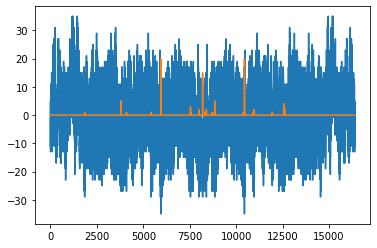

In [14]:
answer = [cost(i,ListOfInt,ListOfJij,nqubits) for i in range(2**nqubits)]
histgram = np.zeros(2**nqubits)
for i in range(len(res)):
    histgram[res[i]] += 1
    
plt.plot(answer)
plt.plot(histgram)
plt.show()

In [4]:
def qa_noisy(nqubits,ListOfInt,ListOfJij,anneal_steps,num_samples,decay_rate_amp,decay_rate_ph):

    hamiltonian = [Observable(nqubits) for i in range(anneal_steps)]
    for i in range(anneal_steps):
        hamiltonian[i] = add_ZZ_interactions(hamiltonian[i],ListOfInt,(1-g[i])*ListOfJij)
        hamiltonian[i] = add_X_fields(hamiltonian[i],g[i])
    #show_observable(hamiltonian[0])
    #show_observable(hamiltonian[-1])


    #ジャンプ演算子の定義
    jump_op_list = [GeneralQuantumOperator(nqubits)  for i in range(2*nqubits)]

    for i in range(nqubits):
        jump_op_list[i].add_operator(decay_rate_ph, "Z {0}".format(i))
        jump_op_list[i+nqubits].add_operator(decay_rate_amp/2*1j, "Y {0}".format(i))
        jump_op_list[i+nqubits].add_operator(decay_rate_amp/2, "X {0}".format(i))

    res = []

    for _ in tqdm.tqdm(range(num_samples)):
        state = QuantumState(nqubits)
        for i in range(nqubits):
            H(i).update_quantum_state(state)

        for i in range(annealing_step):

            #パルスの強度やハミルトニアンが時間的に変動する場合
            #hamiltonian =Observable(nqubits) 
            #hamiltonian.add_operator(pulse_array[i], "Y 0")
            #noisy_operation = NoisyEvolution(hamiltonian, jump_op_list,dt,dt)    
            #dtのノイズのある時間発展
            noisy_operation = NoisyEvolution(hamiltonian[i], jump_op_list,dt,dt)    
            noisy_operation.update_quantum_state(state)

        res.append(state.sampling(1)[0])
    return res

In [5]:
nqubits = 5
num_samples=100
annealing_step = 1000
dt = 0.01 #シミュレーションの時間間隔

# decay rateのリスト
decay_rate_amp = 0.3
decay_rate_ph = 0.3

ListOfInt = [[i,j] for i in range(nqubits) for j in range(i)]
ListOfJij = np.array([(-1)**random.randint(0,1) for i in range(len(ListOfInt))])


#アニーリングのスケジュール
anneal_steps = 1000
g = [1-i*(1/anneal_steps) for i in range(anneal_steps)]  
res = qa_noisy(nqubits,ListOfInt,ListOfJij,anneal_steps,num_samples,decay_rate_amp,decay_rate_ph)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


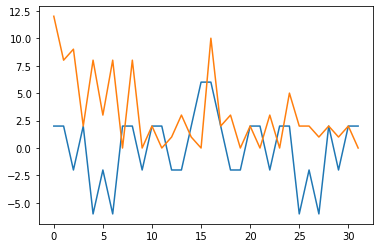

In [6]:
answer = [cost(i,ListOfInt,ListOfJij,nqubits) for i in range(2**nqubits)]
histgram = np.zeros(2**nqubits)
for i in range(len(res)):
    histgram[res[i]] += 1
    
plt.plot(answer)
plt.plot(histgram)
plt.show()

In [7]:
res = qa_ideal(nqubits,ListOfInt,ListOfJij,anneal_steps,num_samples)

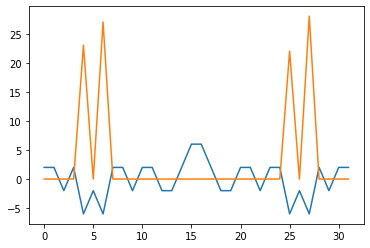

In [8]:
answer = [cost(i,ListOfInt,ListOfJij,nqubits) for i in range(2**nqubits)]
histgram = np.zeros(2**nqubits)
for i in range(len(res)):
    histgram[res[i]] += 1
    
plt.plot(answer)
plt.plot(histgram)
plt.show()